## GENERATE HILLSHADE ACCORDING TO AZIMUTH PER YEAR (RUN ONCE ONLY)

In [1]:
# import os
# import time
# import numpy as np
# import rasterio
# from matplotlib.colors import LightSource
# from tqdm import tqdm  # progress bar

# # ---- input DTM (same grid you used for slope/aspect), output folder ----
# DTM_TIF = r"C:/Users/.../Slope&Aspect+DTM_copy_of_original/swissALTI3D2013_DTM.tif"
# OUT_DIR = r"C:/Users/.../Slope&Aspect+DTM_copy_of_original/hillshades_by_year"
# os.makedirs(OUT_DIR, exist_ok=True)

# # ---- solar geometry: (year, SZA, SAA) ----
# solar = [
#     (2010, 30.6, 130.8), #line052e SZA = 30.6; SAA = 130.8 #updated #old version:(2010, 31.8, 127.5)
#     (2012, 38.4, 114.2), #line022e SZA = 38.4; SAA = 114.2 #updated #old version:(2012, 40.2, 111.3)
#     (2013, 29.3, 140.9), #line022e SZA = 29.3; SAA = 140.9         #remains the same
# ]

# def make_hillshade_from_dtm(dtm_tif, out_hs_tif, azimuth_deg, altitude_deg,
#                             clip_pct=(2, 98)):
#     with rasterio.open(dtm_tif) as src:
#         elev = src.read(1).astype("float32")
#         profile = src.profile.copy()
#         nodata = src.nodata
#         dx, dy = src.res

#     # mask nodata
#     mask = np.zeros_like(elev, dtype=bool)
#     if nodata is not None and np.isfinite(nodata):
#         mask = (elev == nodata)
#         elev = np.where(mask, np.nan, elev)

#     # optional contrast stretch for nicer display
#     if clip_pct:
#         lo, hi = np.nanpercentile(elev, clip_pct)
#         elev = np.clip(elev, lo, hi)

#     # hillshade (values 0..1)
#     ls = LightSource(azdeg=azimuth_deg, altdeg=altitude_deg)
#     hs = ls.hillshade(elev, vert_exag=1.0, dx=dx, dy=dy)
#     if mask.any():
#         hs[mask] = 0.0
#         nodata_out = 0.0
#     else:
#         nodata_out = None

#     profile.update(driver="GTiff", dtype="float32", count=1,
#                    compress="LZW", tiled=True, blockxsize=512, blockysize=512,
#                    nodata=nodata_out)
#     with rasterio.open(out_hs_tif, "w", **profile) as dst:
#         dst.write(hs.astype("float32"), 1)

# # ---- generate one hillshade per year with tqdm + timers ----
# for year, sza, saa in tqdm(solar, desc="Generating hillshades"):
#     start = time.time()
#     altitude = 90.0 - float(sza)   # convert zenith to elevation
#     azimuth  = float(saa)          # assuming SAA is degrees clockwise from North
#     out_hs = os.path.join(OUT_DIR, f"hillshade_{year}_az{saa:.1f}_alt{altitude:.1f}.tif")
#     make_hillshade_from_dtm(DTM_TIF, out_hs, azimuth_deg=azimuth, altitude_deg=altitude)
#     elapsed = time.time() - start
#     tqdm.write(f"✅ {year}: saved {os.path.basename(out_hs)} "
#                f"(az={azimuth:.1f}°, alt={altitude:.1f}°) [{elapsed:.1f}s]")


Generating hillshades:  33%|████████████████████▎                                        | 1/3 [00:25<00:50, 25.38s/it]

✅ 2010: saved hillshade_2010_az130.8_alt59.4.tif (az=130.8°, alt=59.4°) [25.4s]


Generating hillshades:  67%|████████████████████████████████████████▋                    | 2/3 [00:51<00:25, 25.89s/it]

✅ 2012: saved hillshade_2012_az114.2_alt51.6.tif (az=114.2°, alt=51.6°) [26.2s]


Generating hillshades: 100%|█████████████████████████████████████████████████████████████| 3/3 [01:17<00:00, 25.78s/it]

✅ 2013: saved hillshade_2013_az140.9_alt60.7.tif (az=140.9°, alt=60.7°) [25.7s]


## Slope & Aspects

In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box, mapping
from matplotlib import pyplot as plt
import numpy as np
from geopandas.io.file import _to_file
import fiona
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.crs import CRS
from rasterio.windows import Window
from tqdm import tqdm
import glob
from concurrent.futures import ThreadPoolExecutor
np.set_printoptions(suppress=True)
import seaborn as sns
from collections import defaultdict
import rasterio
from pyproj import Transformer
from tkinter import Tk, filedialog
from pathlib import Path

In [2]:
# -------------------------------
# 1) FOLDERS 
# -------------------------------
# Un-comment and set your input folder path:
the_input_folder = "C:/Users/.../Slope&Aspect+DTM_copy_of_original"

def input_path(filename):
    return os.path.join(the_input_folder, filename)

the_output_folder = "./Slope&Aspect_output"  # or any absolute path you prefer

def output_path(filename):
    return os.path.join(the_output_folder, filename)

os.makedirs(the_output_folder, exist_ok=True)

print("Input folder exists:", os.path.isdir(the_input_folder))
print("Output folder:", os.path.abspath(the_output_folder))

Input folder exists: True
Output folder: C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\2nd-paper\phd_ppr2\Slope&Aspect_output


In [ ]:
from tkinter import Tk, filedialog
Tk().withdraw()

DTM_PATH    = filedialog.askopenfilename(title="Select DTM GeoTIFF",    filetypes=[("GeoTIFF", "*.tif")])
SLOPE_PATH  = filedialog.askopenfilename(title="Select Slope GeoTIFF",  filetypes=[("GeoTIFF", "*.tif")])
ASPECT_PATH = filedialog.askopenfilename(title="Select Aspect GeoTIFF", filetypes=[("GeoTIFF", "*.tif")])
POINTS_CSV  = filedialog.askopenfilename(title="Select Points CSV",     filetypes=[("CSV", "*.csv")])

print("DTM   :", DTM_PATH)
print("Slope :", SLOPE_PATH)
print("Aspect:", ASPECT_PATH)
print("CSV   :", POINTS_CSV)

In [6]:
# -------------------------------
# 2) LOAD POINTS (EPSG:2056 / LV95)
# -------------------------------
POINTS_CRS = "EPSG:2056"  # LV95
dffi = pd.read_csv(POINTS_CSV)

# Accept column names for LV95 coordinates
_candidates = [
    ('x','y'), ('X','Y'),
    ('E','N'), ('e','n'),
    ('easting','northing'), ('Easting','Northing'),
    ('X_east','Y_north'), ('x_east','y_north')
]
for cx, cy in _candidates:
    if cx in dffi.columns and cy in dffi.columns:
        px, py = dffi[cx].to_numpy(), dffi[cy].to_numpy()
        break
else:
    raise ValueError(
        "Couldn't find point columns. Use one of: "
        "x,y | X,Y | E,N | e,n | easting,northing | Easting,Northing | X_east,Y_north"
    )

In [7]:
# -------------------------------
# 3) SAMPLING HELPER
# -------------------------------
def sample_raster_at_points(raster_path, xs, ys, points_crs="EPSG:2056"):
    """
    Sample a (single-band) raster at LV95 points.
    If raster CRS != LV95, points are reprojected on the fly.
    """
    with rasterio.open(raster_path) as src:
        if src.crs is None:
            raise ValueError(f"{raster_path} has no CRS defined.")
        rcrs = src.crs

        # Reproject LV95 -> raster CRS if different
        if str(rcrs) != points_crs:
            transformer = Transformer.from_crs(points_crs, rcrs, always_xy=True)
            rx, ry = transformer.transform(xs, ys)
        else:
            rx, ry = xs, ys

        coords = zip(rx, ry)
        vals = [v[0] if len(v) else np.nan for v in rasterio.sample.sample_gen(src, coords)]

        arr = np.asarray(vals, dtype="float64")
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)
        return arr


In [8]:
# -------------------------------
# 4) RUN SAMPLING
# -------------------------------
dffi['elevation'] = sample_raster_at_points(DTM_PATH,   px, py, POINTS_CRS)
dffi['slope']     = sample_raster_at_points(SLOPE_PATH, px, py, POINTS_CRS)
dffi['aspect']    = sample_raster_at_points(ASPECT_PATH,px, py, POINTS_CRS)



In [9]:
# quick preview
dffi.head()

,Object_ID,Year,IS_Img_Date,Agdd,Avg_Temp,Pmm_month,Elevation,Ort,Plot_ID,Plotname,...,Cell_g,Hemic_g,N_g_wet_m2,N_g_dry_m2,Starch_prc,Cell_perc,Hemic_perc,elevation,slope,aspect
0,1,2010,20100624,225.1,9.2,43.4,1821.4,Trupchun Eingang Wiese,AX01,AX01,...,0.127827,0.114716,12.117552,3.780471,51.793290,22.023966,19.764908,1821.719238,5.987199,202.632690
1,2,2010,20100624,225.1,9.2,43.4,2201.6,Alp Trupchun N +,AX02_61,AX02,...,0.136323,0.149786,7.392281,2.571409,43.814090,23.074389,25.353058,2202.860840,34.380894,211.403336
2,3,2010,20100624,225.1,9.2,43.4,2276.4,Alp Trupchun N ++,AX03_58,AX03,...,0.137790,0.161822,8.326865,2.858253,43.424701,23.208734,27.256543,2276.644287,36.838219,225.363098
3,4,2010,20100624,225.1,9.2,43.4,2399.3,Alp Trupchun N +++,AX04_57,AX04,...,0.123945,0.126901,3.687717,1.258903,50.755789,20.813532,21.310022,2399.821289,40.990002,262.041504
4,5,2010,20100624,225.1,9.2,43.4,2485.6,Alp Trupchun N ++++,AX05_55,AX05,...,0.171972,0.159566,2.594882,1.382032,37.139272,29.291857,27.178739,2485.288086,35.952408,244.423676


In [10]:
# Keep only one row per unique location (exact match)
df = dffi.drop_duplicates(subset=["X_east", "Y_north"]).copy()
print(f"Unique locations: {len(df)} of {len(dffi)} total rows")

Unique locations: 113 of 250 total rows


In [11]:
# -------------------------------
# 5) SAVE OUTPUT
# -------------------------------
out_csv = os.path.join(os.path.dirname(POINTS_CSV), "points_with_terrain.csv")
df.to_csv(out_csv, index=False)
print("\nWrote:", out_csv)


Wrote: C:/Users/NargizSafaraliyeva/OneDrive - geo.uzh.ch/Desktop/1st-paper/4th_revisions/RSASE_revision_NR-formatting/Slope&Aspect+DTM_copy_of_original\points_with_terrain.csv


In [12]:
df.slope.min() 
# df.slope.max()
# df.aspect.min()
# df.aspect.max()
# df.elevation.min()
# df.elevation.max()

5.987199306488037

In [13]:
df.aspect.head()

0    202.632690
1    211.403336
2    225.363098
3    262.041504
4    244.423676
Name: aspect, dtype: float64

In [14]:
# ===== 1) BASIC DESCRIPTIVE STATS =====
def basic_stats(series):
    s = series.dropna()
    return pd.Series({
        "count": len(s),
        "mean":  s.mean(),
        "median": s.median(),
        "min":   s.min(),
        "max":   s.max(),
        "std":   s.std(ddof=1)
    })

summary_parts = {}
for col in ["slope", "aspect", "elevation"]:
    if col in df.columns:
        summary_parts[col] = basic_stats(df[col]).round(2)

summary_df = pd.DataFrame(summary_parts)
summary_df

# ===== 2) ASPECT: CIRCULAR STATS (more correct for angles) =====
circ_stats = None
if "aspect" in df.columns:
    a = df["aspect"].dropna().to_numpy()
    # Convert to radians
    t = np.deg2rad(a)
    C = np.cos(t).mean()
    S = np.sin(t).mean()
    # Circular mean (0–360)
    mean_angle = (np.degrees(np.arctan2(S, C)) + 360) % 360
    # Resultant vector length and circular std (in degrees)
    Rbar = np.hypot(C, S)
    circ_std_deg = np.degrees(np.sqrt(-2 * np.log(max(Rbar, 1e-12))))  # guard against log(0)

    circ_stats = pd.DataFrame({
        "aspect_circular_mean_deg": [round(mean_angle, 2)],
        "aspect_circular_std_deg":  [round(circ_std_deg, 2)]
    })

circ_stats

# ===== ASPECT SECTORS (robust, no mismatch) =====
aspect_norm = (df["aspect"].astype(float) % 360 + 360) % 360  # [0,360)

# 8 sectors (0–45=N, 45–90=NE, ..., 315–360=NW)
labels8 = ["N","NE","E","SE","S","SW","W","NW"]
bins8   = [0, 45, 90, 135, 180, 225, 270, 315, 360]  # 9 edges for 8 labels
sector8 = pd.cut(aspect_norm, bins=bins8, labels=labels8, right=False, include_lowest=True)

tab8 = (
    sector8.value_counts(dropna=False)
           .rename_axis("Aspect group")
           .to_frame("Count")
           .sort_index()
)
tab8["Percent"] = (100 * tab8["Count"] / tab8["Count"].sum()).round(1)

# 4 sectors (optional)
labels4 = ["N","E","S","W"]
bins4   = [0, 90, 180, 270, 360]
sector4 = pd.cut(aspect_norm, bins=bins4, labels=labels4, right=False, include_lowest=True)

tab4 = (
    sector4.value_counts(dropna=False)
           .rename_axis("Aspect group")
           .to_frame("Count")
           .sort_index()
)
tab4["Percent"] = (100 * tab4["Count"] / tab4["Count"].sum()).round(1)

# Collect aspect tables into a dict
aspect_tables = {
    "aspect_sectors_8": tab8,
    "aspect_sectors_4": tab4
}

# ===== 4) SAVE TABLES (CSV next to your points CSV if available) =====
# If you used the earlier file picker, POINTS_CSV exists; otherwise change OUT_DIR to where you want the files
OUT_DIR = Path(os.path.dirname(POINTS_CSV)) if "POINTS_CSV" in globals() else Path.cwd()
OUT_DIR.mkdir(parents=True, exist_ok=True)

summary_df.to_csv(OUT_DIR / "topography_summary_stats.csv")
if circ_stats is not None:
    circ_stats.to_csv(OUT_DIR / "aspect_circular_stats.csv", index=False)
for name, table in aspect_tables.items():
    table.to_csv(OUT_DIR / f"{name}.csv")

print("Saved:")
print(" -", OUT_DIR / "topography_summary_stats.csv")
if circ_stats is not None:
    print(" -", OUT_DIR / "aspect_circular_stats.csv")
for name in aspect_tables:
    print(" -", OUT_DIR / f"{name}.csv")


Saved:
 - C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\1st-paper\4th_revisions\RSASE_revision_NR-formatting\Slope&Aspect+DTM_copy_of_original\topography_summary_stats.csv
 - C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\1st-paper\4th_revisions\RSASE_revision_NR-formatting\Slope&Aspect+DTM_copy_of_original\aspect_circular_stats.csv
 - C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\1st-paper\4th_revisions\RSASE_revision_NR-formatting\Slope&Aspect+DTM_copy_of_original\aspect_sectors_8.csv
 - C:\Users\NargizSafaraliyeva\OneDrive - geo.uzh.ch\Desktop\1st-paper\4th_revisions\RSASE_revision_NR-formatting\Slope&Aspect+DTM_copy_of_original\aspect_sectors_4.csv


In [15]:
# Normalize aspect to [0, 360)
aspect_norm = (df["aspect"].astype(float) % 360 + 360) % 360

# 8 equal sectors: N, NE, E, SE, S, SW, W, NW
labels8 = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
bins8   = [0, 45, 90, 135, 180, 225, 270, 315, 360]
sector8 = pd.cut(aspect_norm, bins=bins8, labels=labels8, right=False, include_lowest=True)

# Count and percent
tab8 = (
    sector8.value_counts()
           .rename_axis("Aspect group")
           .to_frame("Count")
           .sort_index()
)
tab8["Percent"] = (100 * tab8["Count"] / tab8["Count"].sum()).round(1)

OUT_DIR = Path.cwd()   # or wherever your other outputs go
tab8.to_csv(OUT_DIR / "PPR1_aspect_sectors_8.csv")

print(tab8)


              Count  Percent
Aspect group                
N                17     15.0
NE                6      5.3
E                 4      3.5
SE                1      0.9
S                26     23.0
SW               32     28.3
W                14     12.4
NW               13     11.5


In [17]:
# Solar geometry data (year, SZA, SAA)
data = [
    (2010, 30.6, 130.8), # old version: (2010, 31.8, 127.5)
    (2012, 38.4, 114.2), # old version: (2012, 40.2, 111.3)
    (2013, 29.3, 140.9)
]

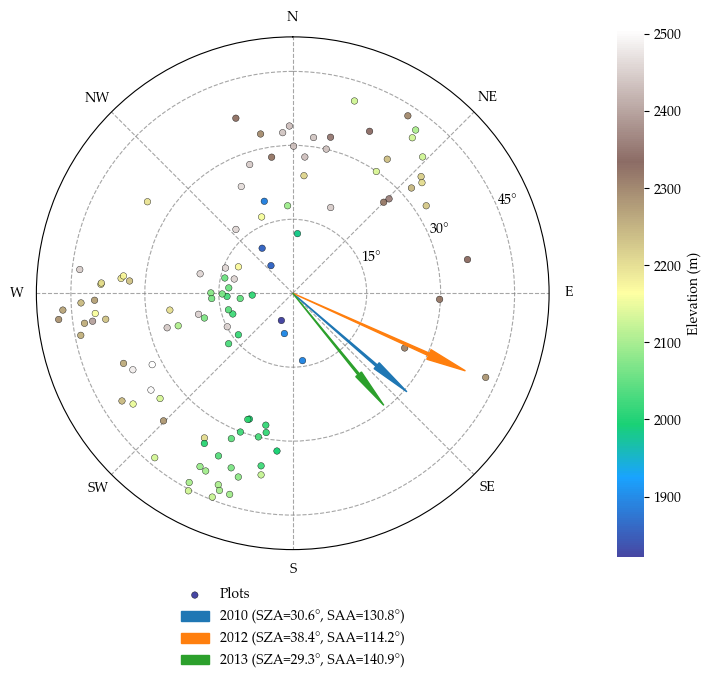

In [18]:
#MAIN

# --- 1) Unique plots by coordinates ---
dfu = df.drop_duplicates(subset=["X_east", "Y_north"]).copy()

# Angle = aspect (0°=N, clockwise), Radius = SLOPE IN DEGREES (literal)
theta_pts = np.deg2rad((dfu["aspect"].astype(float) % 360 + 360) % 360)
slope_deg = dfu["slope"].astype(float).clip(lower=0, upper=90)  # cap at 90° for plotting
r_pts = slope_deg / 90.0

# FONT
plt.rcParams["font.family"] = "Palatino Linotype"

# --- 2) Solar geometry (year, SZA[°], SAA[°]) ---
sun = [(2010, 30.6, 130.8), (2012, 38.4, 114.2), (2013, 29.3, 140.9)]
colors = {2010: 'tab:blue', 2012: 'tab:orange', 2013: 'tab:green'}

# --- 3) Plot ---
fig = plt.figure(figsize=(7.4, 7.4))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Dashed gray gridlines
ax.grid(True, linestyle='--', color='gray', alpha=0.7)

# # Optional: draw a faint radial guide at each year's SAA
# for yr, sza, saa in sun:
#     ax.axvline(np.deg2rad(saa), color=colors[yr], linestyle='--', linewidth=0.8, alpha=0.5, zorder=2)

# Points: coloured by elevation if available
cvals = dfu["elevation"] if "elevation" in dfu.columns else None
sc = ax.scatter(theta_pts, r_pts, s=22, alpha=0.9,
                c=cvals, cmap='terrain' if cvals is not None else None,
                edgecolors='k', linewidths=0.3, zorder=6, label="Plots")

# --- Arrows: angle = SAA, radius = SOLAR ZENITH (°) on the same 0–90° scale as slope ---
for yr, sza, saa in sun:
    theta = np.deg2rad(saa)
    r = sza / 90.0                 # ← use zenith directly (0° at center, 90° at outer ring)
    ax.arrow(theta, 0, 0, r,
             width=0.018, head_width=0.07, head_length=0.09,
             length_includes_head=True, color=colors[yr], zorder=7,
             label=f"{yr} (SZA={sza:.1f}°, SAA={saa}°)")

# Ticks
ax.set_xticks(np.deg2rad([0,45,90,135,180,225,270,315]))
ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW'])
 
rings = [15, 30, 45] # , 60, 75, 90
ax.set_yticks([r/90 for r in rings])
ax.set_yticklabels([f"{r}°" for r in rings])   # degrees for both slope & solar zenith
# ax.text(0, 1.05, "Degrees (slope & solar zenith)", ha="center", va="bottom")  # optional caption
ax.set_rlim(0, 52/90)   # allow radius up to 52°
ax.set_rlabel_position(67.5)

# Legend ABOVE, borderless
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)
# leg = ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=1)
leg.get_frame().set_linewidth(0)
leg.get_frame().set_facecolor("none")

# Colorbar (if elevation was used)
if cvals is not None:
    cbar = fig.colorbar(sc, ax=ax, label="Elevation (m)", shrink=0.8, pad=0.10)
    cbar.outline.set_linewidth(0)

# ax.set_title("Sun positions (arrows) and plot orientations (points)\n"
#              "Angle = aspect / solar azimuth; radius = degrees (slope for points; solar azimuth & zenith angle for arrows)",
#              va='bottom')

plt.tight_layout()
plt.savefig("PPR1_sun_positions_polar_literal_degrees.png", dpi=300, bbox_inches="tight")
plt.savefig("PPR1_sun_positions_polar_literal_degrees.pdf", bbox_inches="tight")
plt.show()
